In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('winequality-white.csv', sep=';')


fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


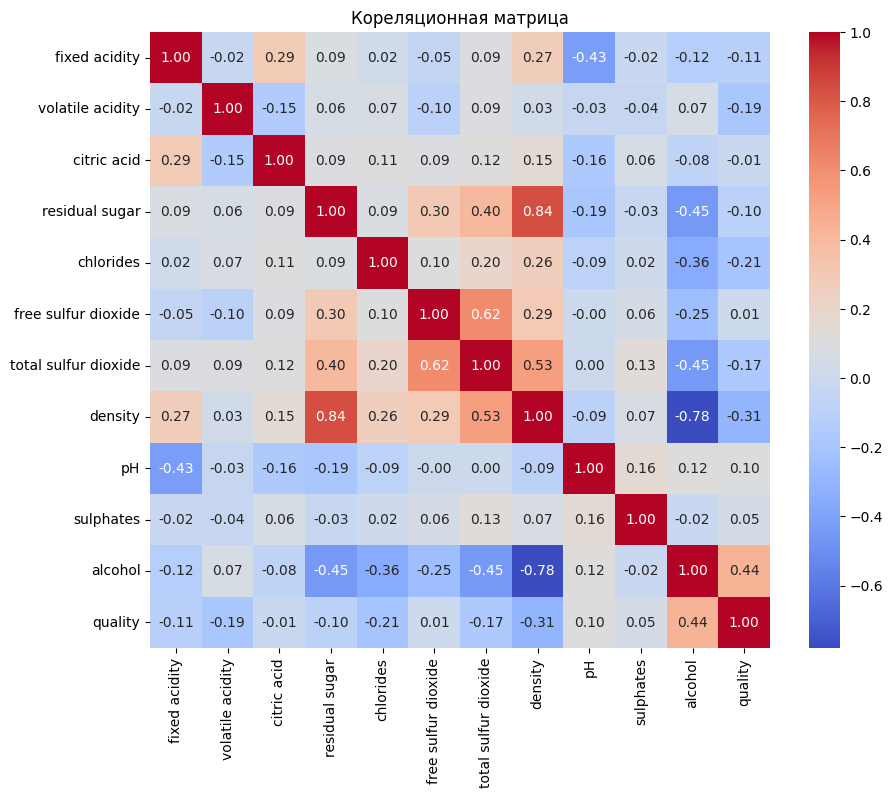

In [26]:
missing_values = data.isnull().sum()
print(missing_values)

# 3. Разведочный анализ (EDA)
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Кореляционная матрица')
plt.show()

# 4. Полезные преобразования данных (Feature Engineering)
threshold = 0.85
high_corr_features = [col for col in corr_matrix.columns if any(abs(corr_matrix[col]) > threshold) and col != 'quality']
features_to_keep = ['alcohol', 'density', 'volatile acidity']
features_to_drop = [col for col in high_corr_features if col not in features_to_keep]
data.drop(columns=features_to_drop, inplace=True)

# 5. Подготовка данных для моделирования
X = data.drop(columns=['quality'])
y = data['quality']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Масштабирование данных
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [27]:
# 7. Построение моделей регрессии
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Линейная регрессия
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Полиномиальная регрессия
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train_scaled, y_train)
y_pred_poly = poly_model.predict(X_test_scaled)

# Ridge регрессия
ridge_params = {'alpha': [0.1, 1.0, 10.0]}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5)
ridge_grid.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_grid.predict(X_test_scaled)

# Lasso регрессия
lasso_params = {'alpha': [0.01, 0.1, 1.0]}
lasso = Lasso()
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5)
lasso_grid.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_grid.predict(X_test_scaled)

In [28]:
def print_model_performance(model_name, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R^2 Score: {r2:.2f}")

print_model_performance('Linear Regression', y_test, y_pred_lr)
print_model_performance('Polynomial Regression', y_test, y_pred_poly)
print_model_performance('Ridge Regression', y_test, y_pred_ridge)
print_model_performance('Lasso Regression', y_test, y_pred_lasso)



Linear Regression Performance:
Mean Squared Error (MSE): 0.59
Mean Absolute Error (MAE): 0.60
R^2 Score: 0.24

Polynomial Regression Performance:
Mean Squared Error (MSE): 0.57
Mean Absolute Error (MAE): 0.59
R^2 Score: 0.26

Ridge Regression Performance:
Mean Squared Error (MSE): 0.59
Mean Absolute Error (MAE): 0.60
R^2 Score: 0.24

Lasso Regression Performance:
Mean Squared Error (MSE): 0.59
Mean Absolute Error (MAE): 0.60
R^2 Score: 0.24


In [29]:
class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        for _ in range(self.n_iterations):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

custom_lr = CustomLinearRegression()

In [35]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

h2o.init()

h2o_data = h2o.H2OFrame(data)

train, test = h2o_data.split_frame(ratios=[0.8], seed=42)

y = 'quality'
x = list(data.columns)
x.remove('quality')

models = {}

linear_model = H2OGeneralizedLinearEstimator(family="gaussian", lambda_=0.0)  #линейная регрессия
linear_model.train(x=x, y=y, training_frame=train)
models['Linear Regression'] = linear_model

for feature in x:
    valid_feature_name = feature.replace(' ', '_').replace('-', '_') 
    poly_feature = train[feature] ** 2 
    poly_feature.set_names([f"{valid_feature_name}_2"]) 
    train = train.cbind(poly_feature)  

x_poly = x + [f"{feature.replace(' ', '_').replace('-', '_')}_2" for feature in x]  # Список признаков теперь включает квадраты

#полиномиальная регрессия
poly_model = H2OGeneralizedLinearEstimator(family="gaussian", lambda_=0.0)
poly_model.train(x=x_poly, y=y, training_frame=train)
models['Polynomial Regression'] = poly_model

#3.Ridge Regression (L2-регуляризация)
ridge_model = H2OGeneralizedLinearEstimator(family="gaussian", lambda_=1.0)  # L2-регуляризация
ridge_model.train(x=x, y=y, training_frame=train)
models['Ridge Regression'] = ridge_model

#4.Lasso Regression (L1-регуляризация)
lasso_model = H2OGeneralizedLinearEstimator(family="gaussian", lambda_=1.0, alpha=1.0)  # L1-регуляризация
lasso_model.train(x=x, y=y, training_frame=train)
models['Lasso Regression'] = lasso_model

for model_name, model in models.items():
    preds_h2o = model.predict(test)
    h2o_y_test = test[y].as_data_frame().values.flatten()
    h2o_y_pred = preds_h2o.as_data_frame().values.flatten()
    
    mse = mean_squared_error(h2o_y_test, h2o_y_pred)
    mae = mean_absolute_error(h2o_y_test, h2o_y_pred)
    r2 = r2_score(h2o_y_test, h2o_y_pred)
  
    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}\n")


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,30 mins 09 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_sofiasvorob_9c05q8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.906 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Linear Regression Performance:
Mean Squared Error (MSE): 0.5910
Mean Absolute Error (MAE): 0.6002
R^2 Score: 0.2114

glm prediction progress: |

/Users/sofiasvorob/.pyenv/versions/3.11.6/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/sofiasvorob/.pyenv/versions/3.11.6/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
Polynomial Regression Performance:
Mean Squared Error (MSE): 9.2665
Mean Absolute Error (MAE): 2.5288
R^2 Score: -11.3653

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Ridge Regression Performance:
Mean Squared Error (MSE): 0.7502
Mean Absolute Error (MAE): 0.6529
R^2 Score: -0.0010

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Lasso Regression Performance:
Mean Squared Error (MSE): 0.7502
Mean Absolute Error (MAE): 0.6529
R^2 Score: -0.0010



/Users/sofiasvorob/.pyenv/versions/3.11.6/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/sofiasvorob/.pyenv/versions/3.11.6/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/sofiasvorob/.pyenv/versions/3.11.6/lib/python3.11/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe

In [36]:
import autosklearn.regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import pandas as pd
import numpy as np

X = data.drop('quality', axis=1)
y = data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {}


linear_model = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=300, per_run_time_limit=60)
linear_model.fit(X_train, y_train)
models['Linear Regression'] = linear_model

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
models['Polynomial Regression'] = poly_model

ridge_model = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=300, per_run_time_limit=60)
ridge_model.fit(X_train, y_train)
models['Ridge Regression'] = ridge_model

lasso_model = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=300, per_run_time_limit=60)
lasso_model.fit(X_train, y_train)
models['Lasso Regression'] = lasso_model

for model_name, model in models.items():

    if model_name == 'Polynomial Regression':
        predictions = model.predict(X_test_poly)
    else:
        predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"{model_name} Performance:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R^2 Score: {r2:.4f}\n")



ModuleNotFoundError: No module named 'autosklearn'